In [1]:
import torch 
import torch.nn as nn #많은 neural network이 담겨있는 모듈입니다. 
import torch.optim as optim  # 많은 optimizer가 담겨있는 모듈입니다. 
import torch.nn.init as init # neural network를 초기화 하는 모듈을 담고 있습니다. 
from torch.utils.data import DataLoader # DataLoader는 데이터를 batch_size만큼 불러오는 역할 등을 수행합니다. 
import torchvision 
import torchvision.datasets as dset # 사진 등의 vision 데이터가 담겨있는 모듈입니다. 
import torchvision.transforms as transforms #이 모듈에는 데이터를 자르고, 반전시키고 tensor로 변환해주기 등의 데이터 변환 함수가 담겨있습니다.  드
import numpy as np
import os 
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
print(torch.__version__)


1.7.0


In [2]:
path = '../input/chest-xray-pneumonia/chest_xray/'
mean = torch.tensor([0.4822])
std = torch.tensor([0.2328])
transformations = transforms.Compose([transforms.Resize((64,64)), 
                              transforms.ToTensor(), 
                              transforms.Normalize(mean, std),
                             ])

In [3]:
train = ImageFolder(os.path.join(path, 'train'), transform=transformations, target_transform=lambda x:np.reshape(np.int(x),(1)))
val = ImageFolder(os.path.join(path, 'val'), transform=transformations, target_transform=lambda x:np.reshape(np.int(x),(1)))
test = ImageFolder(os.path.join(path, 'test'), transform=transformations)

In [4]:
print(train.__getitem__(0)[0].size(), train.__len__())
print(test.__getitem__(0)[0].size(), test.__len__())

print(len(train),len(test))
print(train[0][0][1])


torch.Size([3, 64, 64]) 5216
torch.Size([3, 64, 64]) 624
5216 624
tensor([[-1.7344, -1.5996, -1.0437,  ...,  0.2533, -0.4205, -0.4879],
        [-1.7344, -1.7007, -1.1617,  ..., -0.0499, -0.4879, -0.5384],
        [-1.7176, -1.7512, -1.2964,  ..., -0.3194, -0.5215, -0.6058],
        ...,
        [-1.5996, -1.5996, -1.6333,  ..., -1.7176, -1.7007, -1.6839],
        [-1.5996, -1.6165, -1.6333,  ..., -1.6165, -1.5996, -1.5828],
        [-1.4986, -1.5154, -1.5323,  ..., -0.9258, -0.8921, -0.8584]])


# 하이퍼 파라미터

In [5]:
#CNN에서 대표적인 하이퍼 파라미터로는  num_epoch, batch_size, learnin_rate가 있습니다. 이는 모델에 따라 가감될 수 있습니다. 
num_epoch=10
batch_size=32
learning_rate= 0.0002

# 데이터 로더

In [6]:
#위에서 데이터를 정의했는데 왜 또 데이터를 정의하나요? 라는 의문이 생길 것 같습니다. 
#위에서는 데이터 전부를 정의했습니다. mnist_train에는 모든 학습 데이터가 들어있습니다.
#모든 학습 데이터를 한 번에 학습하면 과부하가 발생할 것입니다. 
#그래서 데이터를 조금씩 조금씩 쪼개서 학습할 필요가 있습니다. 그 역할을 수행하는 것이 DataLodaer이고 때문에 여기서 train_loader,text_loader를 정의하는 것입니다. 
train_loader=DataLoader(dataset=train,batch_size=batch_size,shuffle=True,num_workers=2,drop_last=True)
test_loader=DataLoader(dataset=test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)


# 모델
Conv(1,16,5)->ReLu->Conv(16,32,5)->ReLu->MaxPool2d(2,2)->Conv2d(32,64,5)->ReLu->MaxPool2d(2,2)->fc

In [7]:
#모델을 정의할 때 유념해야할 건 각 층의 결과물의 사이즈입니다. 
#이 층에서 어떤 size를 가진 데이터를 몇 개 도출하는지 정확하게 알고 있어야 정확한 모델을 정의할 수 있습니다. 
#모델이 복잡해지면 복잡해질수록 이는 더욱 중요해집니다. 때문에 모델을 정의할 때 옆에 각 모델이 도출하는 데이터의 크기를 써넣는 것을 추천드립니다. 
#해당 모델은 임의로 만든 모델입니다. 이 모델이 다른 모델보다 뛰어나다는 보장이 없습니다. 
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5),             # [batch_size,1,64,64] -> [batch_size,16,60,60]
            nn.ReLU(),                                                          # 필터의 개수는 1개(흑백이미지)에서 16개로 늘어나도록 임의로 설정했습니다. 
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5),            # [batch_size,16,60,60] -> [batch_size,32,56,56]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),                               # [batch_size,32,56,56] -> [batch_size,32,28,28]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),          # [batch_size,32,28,28] -> [batch_size,64,24,24]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)                                # [batch_size,64,24,24] -> [batch_size,64,12,12]
        )
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(64*12*12,50),                                              # [batch_size,64*12*12] -> [batch_size,50]
            nn.ReLU(),
            nn.Linear(50,2),                                                   # [batch_size,50] -> [batch_size,1]
        )       
        
    def forward(self,x):
        out = self.layer(x)                                                     # self.layer에 정의한 Sequential의 연산을 차례대로 다 실행합니다.
        out=out.view(batch_size,-1)                                           # view 함수를 이용해 텐서의 형태를 [batch_size,나머지]로 바꿔줍니다. 
                                                                                # ex) 2x3 형태였던 텐서를 .view(1,-1) 해주면 1x6의 형태로 바뀝니다. .view(3,-1)이면 3x2로 바뀜.
                                                                                # 만약 전체 텐서의 크기가 batch_size로 나누어 떨어지지 않으면 오류가 납니다.
        out = self.fc_layer(out)
        return out
    def summary(self):
        self.summary()
# https://pytorch.org/docs/stable/nn.html?highlight=conv2d#torch.nn.Conv2d
# https://pytorch.org/docs/stable/tensors.html?highlight=view#torch.Tensor.view




  

# 손실함수

In [8]:
#gpu나 cpu를 device로 불러들입니다. 그리고 device에서 학습이 진행되게끔 모델을 device에 올려놓습니다.
#loss function과 optimizer를 정의하는 것도 잊지 마세요! 
#우리는 torch가 제공하는 걸 가져다 쓰면 됩니당 ~ ^_^  
device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')  

print(device)

model=CNN().to(device)

loss_func=nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

cuda:0


# 학습!!

In [10]:
loss_arr=[]
for i in range(num_epoch):
  for j,[image,label] in enumerate(train_loader):  #아래에서 j를 이용해서 loss를 모으기 위해 이렇게 코드를 짰습니다.
    x= image.to(device)            #학습이미지와 
    y_=label.view(32,).to(device)           #정답을 device에 올려놓습니다.
    optimizer.zero_grad() 
    output=model.forward(x)       #학습이미지를 모델에 돌린 결과를 가져옵니다. 
    loss=loss_func(output,y_)     #결과와 정답을 loss function에 넣고 loss를 추출합니다. 
    loss.backward()               #추출된 loss를 통해 역전파 ! 
    optimizer.step()              #역전파를 했다면 optimizer.step()를 통해 파라미터를 이동시켜줍시다. 
    
    if j%1000==0:
      print(loss)
      loss_arr.append(loss.cpu().detach().numpy())

        
        
    

tensor(0.7810, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1116, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0577, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1034, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0120, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1882, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0581, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0322, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0391, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0258, device='cuda:0', grad_fn=<NllLossBackward>)


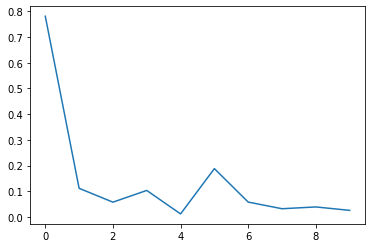

In [11]:
plt.plot(loss_arr)
plt.show()

# 마무리 테스트!

In [14]:
correct=0
total=0

with torch.no_grad():
    for image,label in test_loader:
        x=image.to(device)
        y_=label.view(32,).to(device)
        output=model.forward(x)
     #https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max
        _,output_index=torch.max(output,1)  #max함수는 max value와 max value의 index를 도출합니다. 두 번째 인자 1은 결과의 dimension을 의미합니다. 

        total+=label.size(0)

        correct += (output_index==y_).sum().float()

print("Accuracy of Test Data: {}%".format(100*correct/total))


Accuracy of Test Data: 75.65789794921875%


# 결과 : 아쉽게도 맞출 확률은 75.6퍼여서 좀더 조정이 필요함, 제출후 한번 생각해보겠음